In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


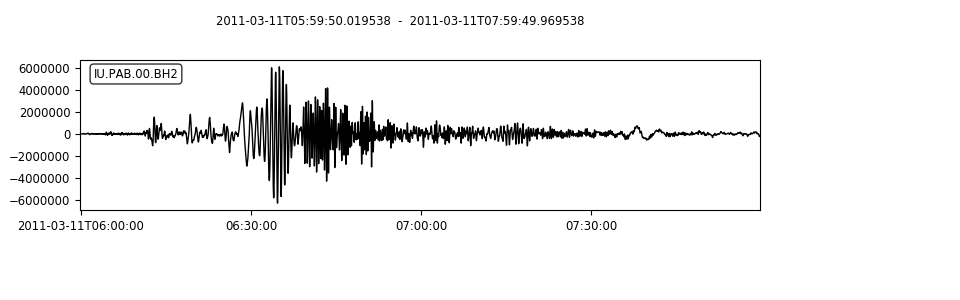

In [13]:
import warnings
warnings.filterwarnings('ignore')
import obspy
import obspy.signal
from obspy import read
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.cross_correlation import correlate,xcorr_max
from IPython.display import display, Markdown
import numpy as np
import copy
st=read("2011-03-11-mw91-near-east-coast-of-honshu-japan-2.miniseed")
# setup the function for interactive picking by right-click on the graphic: 
def onclick(event):
    if event.button == 3: 
        pos.append([event.xdata,event.ydata])
        plt.text(event.xdata, event.ydata, 'o', color='r',weight='bold',\
        horizontalalignment='center',verticalalignment='center')
        print([event.xdata,event.ydata])
def PlotAndClick(ti,tf):
    global fig0
    global cid
    global pos
    i=1;pos=[]
    %matplotlib notebook
    import matplotlib
    import matplotlib.pyplot as plt
    fig0 = plt.figure(figsize=(8,8));
    ax1 = fig0.add_axes([0.1, 0.5, 0.7, 0.45]) #[left bottom width height]
    ax2 = fig0.add_axes([0.1, 0.1, 0.7, 0.35], sharex=ax1)
    t = np.arange(st[i].stats.npts) / st[i].stats.sampling_rate
    tstart=st[i].stats.starttime
    ax1.plot(t, st[i].data, 'k')
    st[i].spectrogram(show=True, axes=ax2,log=True,wlen=200)
    ax2.set_ylim(0.0003,.1)
    ax1.set_xlim(ti*60,tf*60)
    cid=fig0.canvas.mpl_connect('button_press_event', onclick)
def PlotTarr():
    global freqs,tarr
    fig0.canvas.mpl_disconnect(cid)
    def TakeFirst(elem):
        return elem[1]
    posa=sorted(pos,key=TakeFirst)
    posa=np.asarray(posa)
    freqs=posa[:,1];# (store the frequencies in vector freq)
    tarr=posa[:,0]; # (store the arrival times in vector tarr)
    fig = plt.figure(figsize=(10,6));
    ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.45]) #[left bottom width height]
    ax1.plot(freqs, tarr, 'o')
def ComputeApparentVelocity():
    global vels,freqs
    fig0.canvas.mpl_disconnect(cid)
    def TakeFirst(elem):
        return elem[1]
    posa=sorted(pos,key=TakeFirst)
    posa=np.asarray(posa)
    freqs=posa[:,1];# (store the frequencies in vector freq)
    tarr=posa[:,0]; # (store the arrival times in vector tarr)
    Tp=13*60+27;To=2*60;dist=96*111;
    tarra=tarr+Tp-To;
    vels=dist/tarra;
def PlotDispersionCurve():
    fig3,ax3=plt.subplots(figsize=(8,5));
    ax3.plot(1/freqs,vels,'.');ax3.set_xlim(0,1000)
def PlotApproxDepthVelocity():
    deps=np.multiply(vels,.25/freqs)
    fig4,ax4=plt.subplots(figsize=(8,4));
    ax4.plot(vels,deps,'.b');ax4.plot(vels,deps);
    ax4.set_ylim(0,1000);ax4.invert_yaxis()
    ax4.set_xlabel('period (s)')
#%matplotlib inline
#import matplotlib
#import matplotlib.pyplot as plt
st[1].plot(show=False)
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


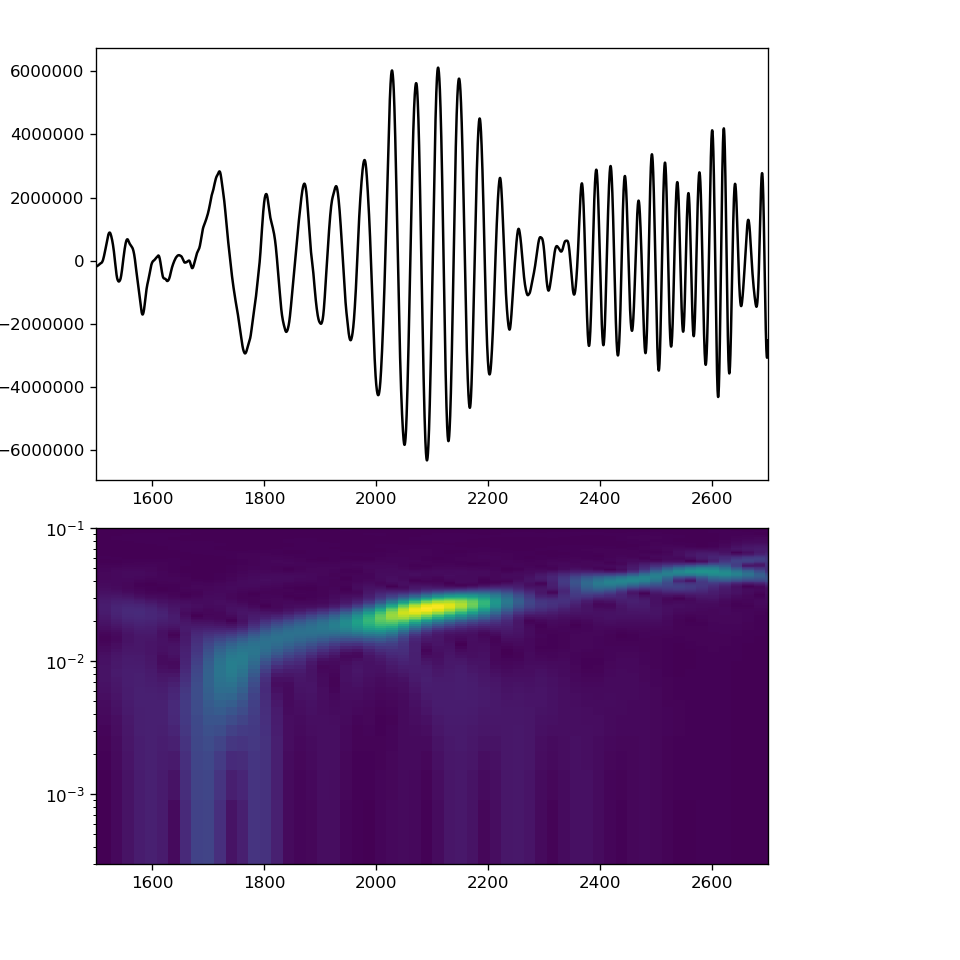

In [14]:
PlotAndClick(25,45)

### Use picked values to : <br> 1) Estimate apparent velocities as Distance / Traveltime for each frequency <br> 2) Make a crude estimate of depth-velocity profile
$$
z\approx \frac{1}{4}\ \frac{c(f)}{f}
$$
where $c$ is velocity and $f$ is frequency

<IPython.core.display.Javascript object>


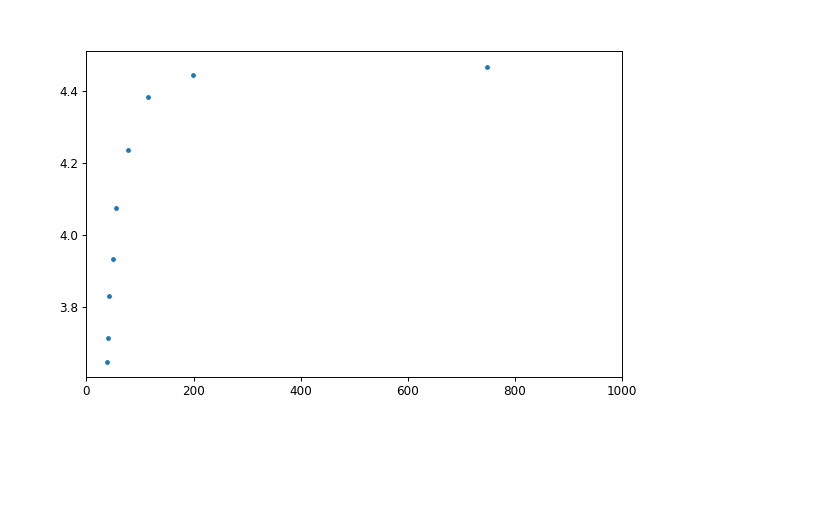

<IPython.core.display.Javascript object>


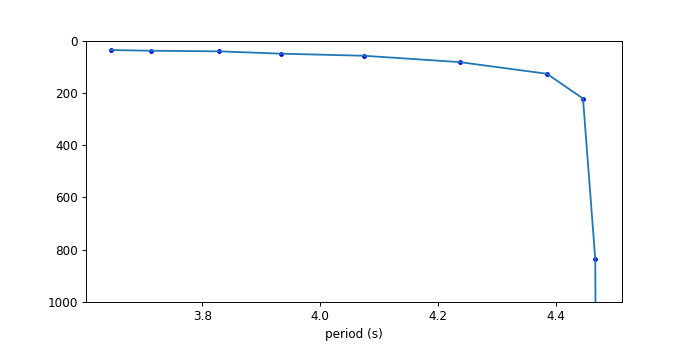

In [3]:
#PlotTarr()
ComputeApparentVelocity()
PlotDispersionCurve()
PlotApproxDepthVelocity()

### Compute the theoretical dispersion curve for a layer over a half space
The velocity $c$ for a given angular frequency $\omega=2\pi f$ is obtained by
solving the equation:
$$
\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} = 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
where: <br>
$H$ is thickness of top layer,<br>
$\beta_1$ and $\beta_2$ are shear wave velocities in top layer and half-space, <br>
$\mu_1$ and $\mu_2$ are shear moduli in top layer and half-space. 

Here a value of $c$ is sought which minimizes the difference defined as :
$$
\textrm{diff}(c)=\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} - 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
To this purpose the python optimization routine __fsolve__ is used.

### Finally, the theoretical prediction (red) is plotted against the dispersion curve (blue) obtained from the spectrogram.


<IPython.core.display.Javascript object>


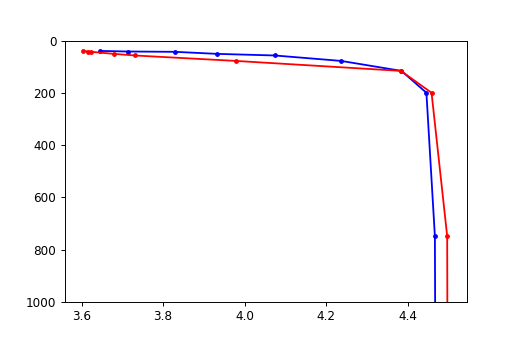

In [4]:
from scipy.optimize import fsolve

b1=3.5;H=45; # these are the values to be "altered"
########################################################
########################################################
#
#
b2=4.5  # assume this "low freq" limit well constrained - keep fixed 
mur=1.5  # assume ratio of elastic moduli is fixed

# define the difference function which needs to be minimised:
def diff(x):
    y = np.tan(w*H*np.sqrt((1/b1**2)-1/x**2) ) \
    - mur*np.sqrt(1/x**2-1/b2**2)/np.sqrt(1/b1**2-1/x**2)
    # Bounce off a very large value of misfit 
    # if velocity higher than fundamental mode.
    # This will avoid selection of other modes:
    if x > cmax: y=1e20 
    return y

# Find the minimum for each frequency value in a loop,
# store results in lists vv (velocities) and and ww (periods):
vv=[];ww=[];
for w in 2*3.1416*freqs:
    cmin=b1;cmax=b2;
    # cmax is maximum velocity for the FIRST mode in the solution
    # becasue tan has infinite solutions for each n*2*pi, we want only n=0. 
    if 1/b1**2 - (1/(2*w*H))**2 > 0:
        cmax=(   1/b1**2 - (1/(2*w*H))**2  )**(-1/2)
    if cmax < cmin: cmax=cmin
    c0 = fsolve(diff, 1.01*cmin)[0]
    vv.append(c0);ww.append(2*3.1416/w)
    
# Plot the theoretical and observed dispersion curves:
fig,ax=plt.subplots()
ax.plot(vels,1/freqs,'.b');ax.plot(vels,1/freqs,'b')
ax.plot(vv,ww,'.r');ax.plot(vv,ww,'r')
#ax.plot(vels,deps);
ax.set_ylim(0,1000)
ax.invert_yaxis()

# Define misfit function to be called with 2 values (b1, H):

In [89]:
def misfit(b1,H):
    from scipy.optimize import fsolve

    #b1=3.55;H=43; # these are the values to be "altered"
    ########################################################
    ########################################################
    #
    #
    b2=4.5  # assume this "low freq" limit well constrained - keep fixed 
    mur=1.5  # assume ratio of elastic moduli is fixed

    # define the difference function which needs to be minimised:
    def diff(x):
        y = np.tan(w*H*np.sqrt((1/b1**2)-1/x**2) ) \
        - mur*np.sqrt(1/x**2-1/b2**2)/np.sqrt(1/b1**2-1/x**2)
        # Bounce off a very large value of misfit 
        # if velocity higher than fundamental mode.
        # This will avoid selection of other modes:
        if x > cmax: y=1e20 
        return y

    # Find the minimum for each frequency value in a loop,
    # store results in lists vv (velocities) and and ww (periods):
    vv=[];ww=[];
    for w in 2*3.1416*freqs:
        cmin=b1;cmax=b2;
        # cmax is maximum velocity for the FIRST mode in the solution
        # becasue tan has infinite solutions for each n*2*pi, we want only n=0. 
        if 1/b1**2 - (1/(2*w*H))**2 > 0:
            cmax=(   1/b1**2 - (1/(2*w*H))**2  )**(-1/2)
        if cmax < cmin: cmax=cmin
        c0 = fsolve(diff, 1.01*cmin)[0]
        vv.append(c0);ww.append(2*3.1416/w)
        
    # Compute the misfit:
    sum=0;
    for i in range(len(vv)):
        sum=sum+(vv[i]-vels[i])**2
        #sum=sum+np.abs((vv[i]-vels[i]))

    return(sum)

## search a number of values in a 50x50 matrix:

In [157]:
mixmiy = np.where(MM == np.amin(MM))
minx=np.asarray(mixmiy)[0]
miny=np.asarray(mixmiy)[1]
minx,miny

(array([35]), array([13]))

In [ ]:
b1s=np.linspace(2,4,50)
Hs=np.linspace(20,50,50)
MM = [[0 for y in range(len(b1s))] for x in range(len(Hs))]
MM=np.array(MM,dtype=np.float)
for i in range(len(b1s)):
    for j in range(len(Hs)):
        MM[i,j]=misfit(b1s[i],Hs[j])
BB, HH = np.meshgrid(b1s, Hs)

## Plot the result as a colormap

<IPython.core.display.Javascript object>


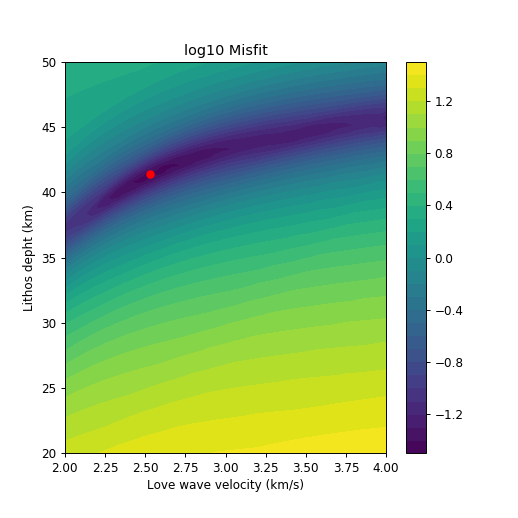

In [160]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.transforms
from matplotlib import ticker,cm
import matplotlib.colors as colors
import numpy as np
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
vmin=np.amin(np.array(MM)[MM != np.amin(MM)])
plo=ax.contourf(BB,HH,np.log10(MM),30)
ax.set_xlabel("Love wave velocity (km/s)")
ax.set_ylabel("Lithos depht (km)")
ax.set_title('log10 Misfit')
mixmiy = np.where(MM == np.amin(MM))
minx=np.asarray(mixmiy)[0][0]
miny=np.asarray(mixmiy)[1][0]
ax.plot(BB[minx,miny],HH[minx,miny],'ro')
fig.colorbar(plo)